In [83]:
!git clone https://github.com/Anonymous-GT11/SAFRAN_ENSAI_2025
# Verify that we have sucessfully clone the repo and go the place where the repo is stored
%cd /content/SAFRAN_ENSAI_2025
!ls


fatal: destination path 'SAFRAN_ENSAI_2025' already exists and is not an empty directory.
/content/SAFRAN_ENSAI_2025
data			performancemodel_ENSAI.zip  SAFRAN_ENSAI_2025
performancemodel_ENSAI	README.md


In [84]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install torch-geometric-temporal

2.8.0+cu126
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [85]:
from torch_geometric_temporal.dataset import MTMDatasetLoader
from torch_geometric_temporal.signal import StaticGraphTemporalSignal

# Load the MTMdataset from Pytorch Geometric Temporal


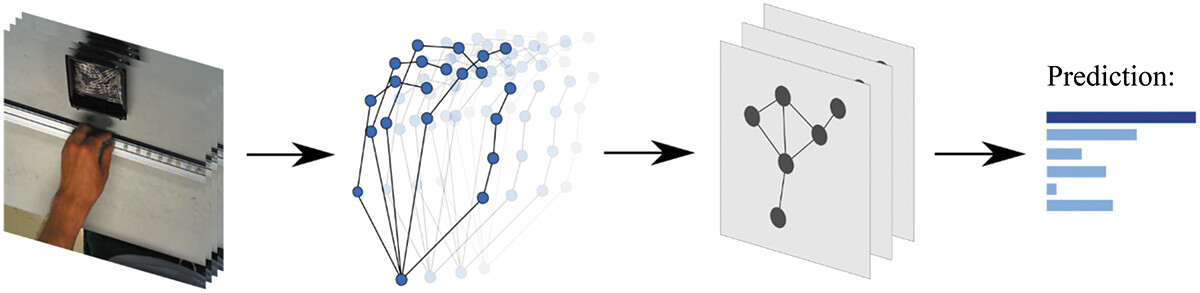

A dataset of Methods-Time Measurement-1 (MTM-1) motions, signalled as consecutive video frames of 21 3D hand keypoints, acquired via MediaPipe Hands from RGB-Video material. Vertices are the finger joints of the human hand and edges are the bones connecting them. The targets are manually labeled for each frame, according to one of the five MTM-1 motions (classes
): Grasp, Release, Move, Reach, Position plus a negative class for frames without graph signals (no hand present). This is a classification task where
 consecutive frames need to be assigned to the corresponding class
. The data x is returned in shape (3, 21, T), the target is returned one-hot-encoded in shape (T, 6).

[lWikipedia of the Methods-time measurement system](https://en.wikipedia.org/wiki/Methods-time_measurement)

In [86]:
# we prepare a function to load the dataset
def load_dataset(n_frames):
  # Load original dataset
  loader = MTMDatasetLoader()
  dataset = loader.get_dataset(frames = n_frames)

  # Extract components of the temporal dataset
  # These are lists (or iterables) over time
  edge_index = dataset.edge_index
  edge_weight = dataset.edge_weight
  features = dataset.features
  targets = dataset.targets

  # Transpose the feature tensors and convert to float
  # Each feature tensor originally has shape (3, 21, n_frames)
  # We want to make it (21, 3, n_frames) that represents 21 nodes, each has a feature  size 3 x n_frames
  new_features = [torch.from_numpy(x).permute(1, 0, 2).float() for x in features]

  # Create a new StaticGraphTemporalSignal with the modified features
  new_dataset =  StaticGraphTemporalSignal(
      edge_index=edge_index,
      edge_weight=edge_weight,
      features=new_features,
      targets=targets
  )
  return new_dataset

## First, let's try load frame by frame.


In [87]:
dataset = load_dataset(n_frames=1)

# This dataset contain 14k objects, each is a graph data object
# for example
data = dataset[190]  # Get a graph object

print()
print(data)
print('=============================================================')
print(f'Number of edges: {data.num_edges}')
print(f'Number of nodes: {data.num_nodes}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')


Data(x=[21, 3, 1], edge_index=[2, 19], edge_attr=[19], y=[1, 6])
Number of edges: 19
Number of nodes: 21
Average node degree: 0.90


In [88]:
# the target output associated with this one frame is a binary vector size 6
# representing if this frame belongs to which class.
data.y

tensor([[0., 1., 0., 0., 0., 0.]])

You guys can start working with this dataset frame-by-frame. However, as you can guess, it is very difficult to get a right prediction of a hand motion using only one frame. Therefore, we should use multiple frames.

## Second, load multiple frames:

Here, we have a moving windows of size 16 that sweeps through the whole dataset. Therefore, we will also have 14k data point:

In [89]:
dataset = load_dataset(n_frames=16)

# This dataset contain 14k objects, each is a graph data object
# for example
data = dataset[190]  # Get a graph object

print()
print(data)
print('=============================================================')
print(f'Number of edges: {data.num_edges}')
print(f'Number of nodes: {data.num_nodes}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')


Data(x=[21, 3, 16], edge_index=[2, 19], edge_attr=[19], y=[16, 6])
Number of edges: 19
Number of nodes: 21
Average node degree: 0.90


This time, the node feature is of size 3 x 16.

Moreover, the target label is 16 vectors, each have size 6. In order to simplfy the problem, you should write a code that taking this [16,6] tensor as input and output a bianry [1,6] tensor, where the element that most presents in the [16,6] will have value 1, while the rest zeros. In other words, you look at the 16 frames in your data point, and assign the class that presents the most as the class of the data point.

In the end, you should have, for each data point data in dataset, data.y is a [1,6] vector.

# Task 1: preparing training and testing dataset
- Using shufffle (see notebook 3) to create dataset, I suggest to you 20% percent test, and 80% train.
- Using mini batches help a lot as your dataset is quite large here



In [95]:
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
import numpy as np

# Load dataset with 16 frames
dataset = load_dataset(n_frames=16)

# Function to convert multi-frame labels to single label (most common class)
def convert_dataset(dataset):
    new_dataset = []
    for data in dataset:
        # Get the class index for each frame
        class_indices = torch.argmax(data.y, dim=1)

        # Find the most frequent class index
        most_common_class = torch.mode(class_indices).values

        # Create a one-hot encoded tensor for the most common class
        new_y = torch.zeros(1, 6)
        new_y[0, most_common_class] = 1

        # Create new data object with simplified label
        new_data = Data(
            x=data.x,
            edge_index=data.edge_index,
            edge_attr=data.edge_attr,
            y=new_y
        )
        new_dataset.append(new_data)
    return new_dataset

# Simplify dataset
simplified_dataset = convert_dataset(dataset)

# Shuffle and split dataset (80% train, 20% test)
indices = np.random.permutation(len(simplified_dataset))
split_idx = int(0.8 * len(simplified_dataset))

train_indices = indices[:split_idx]
test_indices = indices[split_idx:]

train_dataset = [simplified_dataset[i] for i in train_indices]
test_dataset = [simplified_dataset[i] for i in test_indices]

# Create DataLoaders with mini-batches
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Training samples: 11562
Test samples: 2891
Number of training batches: 181
Number of test batches: 46


# Task 2: Training an  testing MLP
Here, using only features vectors and not the graph info

In [98]:
# We start by defining a very simple MLP with two layers
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import global_mean_pool
import torch.nn as nn # Import nn module

class MLP(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = nn.Linear(input_dim, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        # x has shape [batch_size * num_nodes, num_features, num_frames]
        # Flatten the features: [batch_size * num_nodes, num_features * num_frames]
        x = data.x.reshape(data.x.size(0), -1)

        # Perform layer operations
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)

        # Pool node features to graph level
        x = global_mean_pool(x, data.batch)

        return x


# Initialize MLP model
input_dim = 3 * n_frames
hidden_dim = 128
output_dim = 6

mlp_model = MLP(input_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.005)
criterion = torch.nn.CrossEntropyLoss()


def train(model, loader):
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data)  # Perform a single forward pass.
         labels = data.y.argmax(dim=1)  # Get class indices from one-hot encoded labels
         loss = criterion(out, labels)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.


def test(model, loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data)
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         labels = data.y.argmax(dim=1)  # Get class indices from one-hot encoded labels
         correct += int((pred == labels).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 51):
    train(mlp_model, train_loader)
    train_acc = test(mlp_model, train_loader)
    test_acc = test(mlp_model, test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 0.6002, Test Acc: 0.6026
Epoch: 002, Train Acc: 0.6559, Test Acc: 0.6617
Epoch: 003, Train Acc: 0.7098, Test Acc: 0.7036
Epoch: 004, Train Acc: 0.7244, Test Acc: 0.7122
Epoch: 005, Train Acc: 0.7394, Test Acc: 0.7357
Epoch: 006, Train Acc: 0.7532, Test Acc: 0.7475
Epoch: 007, Train Acc: 0.7666, Test Acc: 0.7596
Epoch: 008, Train Acc: 0.7647, Test Acc: 0.7534
Epoch: 009, Train Acc: 0.7528, Test Acc: 0.7388
Epoch: 010, Train Acc: 0.7794, Test Acc: 0.7762
Epoch: 011, Train Acc: 0.7697, Test Acc: 0.7579
Epoch: 012, Train Acc: 0.7788, Test Acc: 0.7727
Epoch: 013, Train Acc: 0.7700, Test Acc: 0.7662
Epoch: 014, Train Acc: 0.7977, Test Acc: 0.7904
Epoch: 015, Train Acc: 0.7967, Test Acc: 0.7869
Epoch: 016, Train Acc: 0.7977, Test Acc: 0.7994
Epoch: 017, Train Acc: 0.8073, Test Acc: 0.7987
Epoch: 018, Train Acc: 0.8044, Test Acc: 0.7987
Epoch: 019, Train Acc: 0.8153, Test Acc: 0.8087
Epoch: 020, Train Acc: 0.8011, Test Acc: 0.7966
Epoch: 021, Train Acc: 0.8081, Test Acc:

# Task 3: Training and testing GNN:

In [101]:
from torch_geometric.nn import GCNConv, global_mean_pool

class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.lin = Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # Flatten temporal dimension into features
        # x has shape [num_nodes, 3, 16] -> reshape to [num_nodes, 48]
        x = x.reshape(x.size(0), -1)

        # Perform layer operations
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)

        # Global pooling (aggregate node features to graph level)
        x = global_mean_pool(x, batch)

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

# Initialize GNN model
input_dim = 3 * n_frames
hidden_dim = 128
output_dim = 6

gnn_model = GNN(input_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()

# Train GNN
for epoch in range(1, 51):
    train(gnn_model, train_loader)
    train_acc = test(gnn_model, train_loader)
    test_acc = test(gnn_model, test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

# Compare results
print("\n" + "="*50)
print("COMPARISON:")
print(f"MLP Test Accuracy: {test(mlp_model, test_loader):.4f}")
print(f"GNN Test Accuracy: {test(gnn_model, test_loader):.4f}")
print("="*50)

Epoch: 001, Train Acc: 0.6371, Test Acc: 0.6306
Epoch: 002, Train Acc: 0.6751, Test Acc: 0.6655
Epoch: 003, Train Acc: 0.7011, Test Acc: 0.7011
Epoch: 004, Train Acc: 0.7231, Test Acc: 0.7132
Epoch: 005, Train Acc: 0.7472, Test Acc: 0.7430
Epoch: 006, Train Acc: 0.7321, Test Acc: 0.7254
Epoch: 007, Train Acc: 0.7541, Test Acc: 0.7548
Epoch: 008, Train Acc: 0.7543, Test Acc: 0.7485
Epoch: 009, Train Acc: 0.7734, Test Acc: 0.7644
Epoch: 010, Train Acc: 0.7830, Test Acc: 0.7804
Epoch: 011, Train Acc: 0.7807, Test Acc: 0.7810
Epoch: 012, Train Acc: 0.7859, Test Acc: 0.7824
Epoch: 013, Train Acc: 0.7819, Test Acc: 0.7759
Epoch: 014, Train Acc: 0.8022, Test Acc: 0.7942
Epoch: 015, Train Acc: 0.7730, Test Acc: 0.7714
Epoch: 016, Train Acc: 0.7645, Test Acc: 0.7617
Epoch: 017, Train Acc: 0.7872, Test Acc: 0.7845
Epoch: 018, Train Acc: 0.7903, Test Acc: 0.7859
Epoch: 019, Train Acc: 0.7959, Test Acc: 0.7814
Epoch: 020, Train Acc: 0.8009, Test Acc: 0.7994
Epoch: 021, Train Acc: 0.8059, Test Acc: